In [55]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pyautogui as pag
import random
import time
import requests
import pickle
import re
import json
import solver
from tqdm.notebook import trange
from tqdm.notebook import tqdm

ALPHABET = "abcdefghijklmnopqrstuvwxyz"

In [71]:
def verrify_all_letters_used_in_soln(board, soln) -> bool:
    # Does this work for repeated letters?
    return all(any(letter in word for word in soln) for letter in board if letter != " ")

def print_board(board):
    n = int(np.sqrt(len(board)))
    for i in range(n):
        print(board[n*i:n*(i+1)])

def get_word_list(four_letter_min=True) -> list[str]:
    words = []
    with open("words.txt", "r") as f:
        words = [line.strip() for line in f.readlines() if not four_letter_min or len(line.strip()) >= 4]
    return words

def get_word_freq_dict(four_letter_min=True, normalize=True) -> dict[str, float]:
    freqs = {}
    with open("freqs.pkl", "rb") as f:
        freqs = {k: v for k,v in pickle.load(f).items() if not four_letter_min or len(k) >=4}
    if normalize:
        freq_sum = sum(freqs.values())
        return {k: v / freq_sum for k, v in freqs.items()}
    return freqs

def get_unweighted_letter_freq_dict(four_letter_word_min=True) -> dict[str, float]:
    all_words = "".join(get_word_list(four_letter_word_min))
    return {c: all_words.count(c)/len(all_words) for c in ALPHABET}

def get_weighted_letter_freq_dict(four_letter_word_min=True) -> dict[str, float]:
    word_freqs = get_word_freq_dict(four_letter_min=four_letter_word_min)
    letter_freqs = {letter: sum(freq*word.count(letter) for word, freq in word_freqs.items() if letter in word) for letter in ALPHABET}
    return {k: v / sum(letter_freqs.values()) for k, v in letter_freqs.items()}

def plot_letter_freq_comparisons():
    # Get different frequency dicts
    unweighted_letter_freqs_all = get_unweighted_letter_freq_dict(False)
    unweighted_letter_freqs_4plus = get_unweighted_letter_freq_dict()
    weighted_letter_freqs_all = get_weighted_letter_freq_dict(False)
    weighted_letter_freqs_4plus = get_weighted_letter_freq_dict()

    # Plot bar charts
    plt.bar(range(26), [unweighted_letter_freqs_all[c] for c in ALPHABET], alpha=0.25, label="Unweighted (all)")
    plt.bar(range(26), [unweighted_letter_freqs_4plus[c] for c in ALPHABET], alpha=0.25, label="Unweighted (>3)")
    plt.bar(range(26), [weighted_letter_freqs_all[c] for c in ALPHABET], alpha=0.25, label="Weighted (all)")
    plt.bar(range(26), [weighted_letter_freqs_4plus[c] for c in ALPHABET], alpha=0.25, label="Weighted (>3)")
    plt.xticks(range(26), list(ALPHABET))
    plt.xlabel("Letter")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

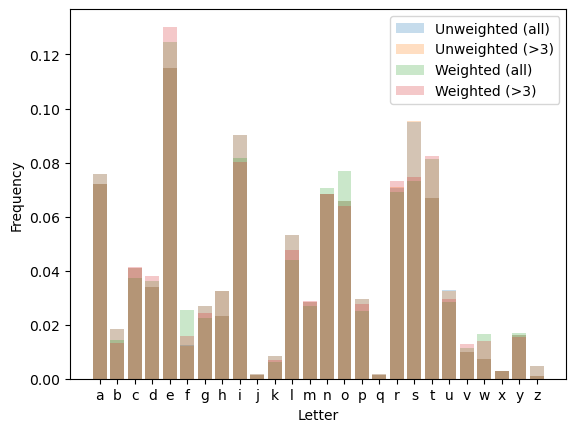

In [72]:
plot_letter_freq_comparisons()

In [73]:
letter_freq_dict = get_weighted_letter_freq_dict()
letter_freq_list = [letter_freq_dict[c] for c in ALPHABET]
word_freqs = get_word_freq_dict()

In [81]:
def generate_trial_board(n):
    return "".join(random.choices(ALPHABET, weights=letter_freq_list, k=n**2))

def generate_puzzle(
        n, 
        min_longest_word_len=None,
        min_word_count=None,
        min_word_freq=None,
        enforce_all_letters_used=True, 
        holes=None):
    while True:
        # Get a random board
        board = generate_trial_board(n)
        
        # Make any holes
        if holes:
            for h in holes:
                board = board[:h] + " " + board[h+1:]

        # Get solution
        soln = solver.solve(board)
        
        # Check all letters used
        if enforce_all_letters_used and not verrify_all_letters_used_in_soln(board, soln):
            continue
        
        # check word count
        if min_word_count and len(soln) < min_word_count:
            continue

        # check min word frequency
        if min_word_freq and any(word_freqs[word] < min_word_freq for word in soln):
            continue

        # Check longest word length
        if min_longest_word_len and max(len(word) for word in soln) < min_longest_word_len:
            continue

        return board, soln

In [125]:
board, soln = generate_puzzle(4)

tiio
emma
nean
ertm

Total words: 98
Mean word frequency: 0.000058
High-frequency words: 30
Low-frequency words: 68
Mean high-frequency word frequency: 0.000186
['omit', 'mamma', 'meta', 'mama', 'tree', 'rate', 'amen', 'teen', 'meant', 'mare', 'neat', 'meet', 'mere', 'mean', 'earn', 'mart', 'timer', 'mate', 'mater', 'ante', 'tear', 'name', 'memo', 'tame', 'meat', 'time', 'item', 'near', 'metre', 'team']


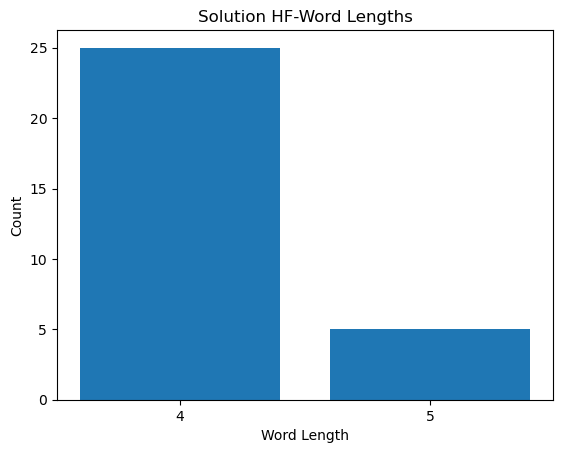

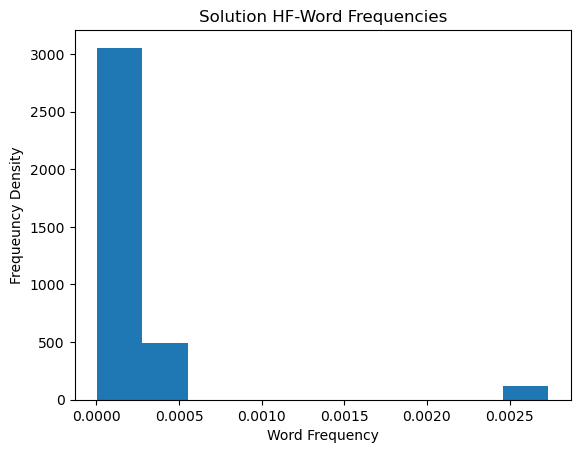

In [126]:
total_words = len(soln)

soln_word_lens = [len(word) for word in soln]
min_word_len, max_word_len = min(soln_word_lens), max(soln_word_lens)

soln_word_freqs = [word_freqs[word] for word in soln]
min_word_freq, max_word_freq = min(soln_word_freqs), max(soln_word_freqs)

print_board(board)
print(f"\nTotal words: {total_words}")
print(f"Mean word frequency: {np.mean(soln_word_freqs):.6f}")

low_freq_cutoff = 5e-6

high_freq_words = [word for word in soln if word_freqs[word] > low_freq_cutoff]
low_freq_words = [word for word in soln if word_freqs[word] <= low_freq_cutoff]
print(f"High-frequency words: {len(high_freq_words)}")
print(f"Low-frequency words: {len(low_freq_words)}")

high_freq_word_freqs = [word_freqs[word] for word in high_freq_words]
print(f"Mean high-frequency word frequency: {np.mean(high_freq_word_freqs):.6f}")

print(high_freq_words)

# plt.bar(range(4, max_word_len+1), [soln_word_lens.count(i) for i in range(4, max_word_len+1)])
# plt.xticks(range(4, max_word_len+1))
# plt.xlabel("Word Length")
# plt.ylabel("Count")
# plt.title("Solution Word Lengths")
# plt.show()

# plt.hist(soln_word_freqs, density=True)
# plt.xlabel("Word Frequency")
# plt.ylabel("Frequeuncy Density")
# plt.title("Solution Word Frequencies")
# plt.show()

hf_word_lens = [len(word) for word in high_freq_words]
hf_word_freqs = [word_freqs[word] for word in high_freq_words]
max_hf_word_len = max(len(word) for word in high_freq_words)

plt.bar(range(4, max_hf_word_len+1), [hf_word_lens.count(i) for i in range(4, max_hf_word_len+1)])
plt.xticks(range(4, max_hf_word_len+1))
plt.xlabel("Word Length")
plt.ylabel("Count")
plt.title("Solution HF-Word Lengths")
plt.show()

plt.hist(hf_word_freqs, density=True)
plt.xlabel("Word Frequency")
plt.ylabel("Frequeuncy Density")
plt.title("Solution HF-Word Frequencies")
plt.show()


In [ ]:
n = 4
low_freq_cutoff = 5e-6
best_max_word_len = 0
best_avg_word_freq = 0
best_max_word_len_board = ""
best_avg_word_freq_board = ""
puzzles = []
while True:
    board, soln = generate_puzzle(n)
    high_freq_words = [word for word in soln if word_freqs[word] > low_freq_cutoff]
    max_word_len = max(len(word) for word in high_freq_words)
    avg_freq = np.mean([word_freqs[word] for word in high_freq_words])

    if max_word_len > best_max_word_len:
        best_max_word_len = max_word_len
        best_max_word_len_board = board
        print(f"New best max word len: {best_max_word_len}")

    if avg_freq > best_avg_word_freq:
        best_avg_word_freq = avg_freq
        best_avg_word_freq_board = board
        print(f"New best avg word freq: {best_avg_word_freq:.6f}")

    puzzles.append((board, soln))
    

New best max word len: 8
New best avg word freq: 0.000141
New best avg word freq: 0.000213
New best avg word freq: 0.000215
New best avg word freq: 0.000362
New best avg word freq: 0.000624
New best max word len: 9
New best avg word freq: 0.001432
New best avg word freq: 0.001566


ValueError: max() iterable argument is empty

In [ ]:
n = 3
max_word_len = 0
while max_word_len < 8:
    rand_board = "".join(random.choices(ALPHABET, weights=letter_freqs, k=n**2))
    soln = solve(rand_board)
    if not verrify_all_letters_used_in_soln(rand_board, soln):
        continue
    num_words, max_word_len = len(soln), max(len(s) for s in soln)

print_board(rand_board)
print(f"Number of words: {num_words}")
print(f"Max word length: {max_word_len}")

ets
cao
crd
Number of words: 66
Max word length: 8
